In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import wandb
import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
rng = np.random.default_rng(12345)

2024-04-29 22:52:00.981855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 22:52:00.981891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 22:52:00.983715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 22:52:00.992439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 22:52:02.845489: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def check_wide(value):
    if value[1] < -2.5*value[0]+1.15:
        return False
    if value[1] > -2.5*value[0]+1.9:
        return False
    return True

def check_narrow(value):
    if value[0] < .15 or value[0] > .45:
        return False
    if value[1] < .5 or value[1] > 1.3:
        return False
    if value[1] < -2.5*value[0]+1.3:
        return False
    if value[1] > -2.5*value[0]+1.8:
        return False
    return True


def make_cosmogrid(value):
    wide = check_wide(value)
    narrow = check_narrow(value)
    if not wide:
        return False
    if not narrow:
        return np.random.choice([True, False], p=[.5, .5])
    return True

N_train=73738, N_val=9102, N_test=6302



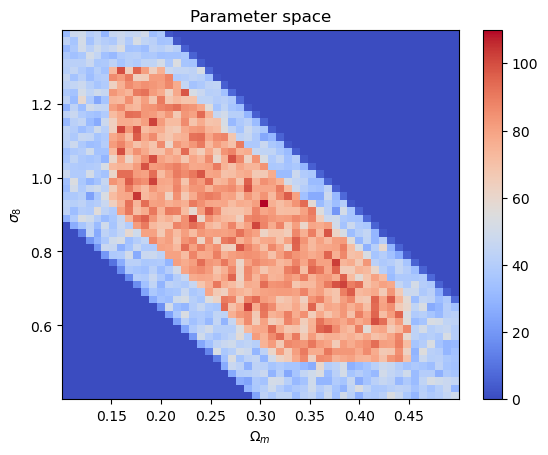

In [12]:
min_scale = 6 
nsims = 200000

savepath = '../data/run2/'

theta = np.load(savepath + 'theta.npy')[:nsims] #[Om, s8, w, n_s, Ob, H0, ia , dnz1, dnz2, dnz3, dnz4, mpb1, mpb2, mpb3, mpb4, id]
theta_fixed = theta[:,2::1]
theta = theta[:,:2]


xip = np.load(savepath + 'xip.npy')[:nsims]
xim = np.load(savepath + 'xim.npy')[:nsims]

xi = np.concatenate((xip[:,:,min_scale:,None], xim[:,:,min_scale:,None]), axis=3)
xi_flat = xi.reshape(xi.shape[0], -1)


base_path_fiducial = '../data/CosmoGrid/fiducial/'
xip_fiducial = np.load(base_path_fiducial + 'xip.npy')[:,:,:,min_scale:].reshape(800,-1)
xim_fiducial = np.load(base_path_fiducial + 'xim.npy')[:,:,:,min_scale:].reshape(800,-1)
xi_fiducial = np.concatenate((xip_fiducial, xim_fiducial), axis=1)


cov = np.cov(xi_fiducial.T)
noise = rng.multivariate_normal(np.zeros(xi_fiducial.shape[1]), cov, xi_flat.shape[0])
xi_flat += noise

x = xi_flat


cosmogrid_inds = np.apply_along_axis(make_cosmogrid, 1, theta)
x = x[cosmogrid_inds]        
theta = theta[cosmogrid_inds]

plt.hist2d(theta[:,0], theta[:,1], bins=50, density=False, cmap='coolwarm', norm='linear')
plt.title("Parameter space")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")
plt.colorbar()

y = theta[:,1] * np.sqrt(theta[:,0] / 0.3)
y_mean = y.mean(axis=0)
y_std = np.max(np.abs(y - y_mean))

val_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)
test_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)


y_val = (y[val_inds] - y_mean) / y_std
x_val = x[val_inds]
y_test = y[test_inds]
x_test = x[test_inds]
y_train = (np.delete(y, [val_inds, test_inds], axis=0) - y_mean) / y_std
x_train = np.delete(x, [val_inds, test_inds], axis=0)


x_test = x_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]
y_test = y_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]

s8_min = y_test.min()
s8_max = y_test.max()


print(f"N_train={x_train.shape[0]}, N_val={x_val.shape[0]}, N_test={x_test.shape[0]}\n")



In [4]:
def build_model():
    
    regularizer = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    regularizer_b = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    
    input = Input(shape=(x.shape[1],), name="Input")
    y = input
    y = BatchNormalization(name='BatchNorm_1')(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_1')(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_2')(y)
    y = Dense(128, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_3')(y)
    y = Dense(64, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_64_1')(y)
    y = Dense(16, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_16_1')(y)
    y = Dense(1, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Output')(y)
    
    return Model(inputs=input, outputs=y)

model = build_model()
model.load_weights('../models/model_run1.keras')

for i in range(1, len(model.layers)-2):
    model.layers[i].trainable = False

model.summary()

loss = tf.keras.losses.MeanSquaredError()
checkpoint = ModelCheckpoint(filepath='../models/model.keras', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=2)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True, verbose=2),
            checkpoint,
            tensorboard,
            ReduceLROnPlateau(patience=20, monitor='val_loss', verbose=2, factor=0.1, restore_best_weights=True),
            ReduceLROnPlateau(patience=10, monitor='loss', verbose=2, factor=0.1, restore_best_weights=True),
            ]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 180)]             0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 180)               720       
 ation)                                                          
                                                                 
 Dense_128_1 (Dense)         (None, 128)               23168     
                                                                 
 Dense_128_2 (Dense)         (None, 128)               16512     
                                                                 
 Dense_128_3 (Dense)         (None, 128)               16512     
                                                                 
 Dense_64_1 (Dense)          (None, 64)                8256      
                                                             

2024-04-29 22:52:11.588662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77773 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:5b:00.0, compute capability: 8.0


In [5]:
#wandb.init(project='reverse_emulator', sync_tensorboard=True)


for lr in np.logspace(-8, -3, 6)[:-1]:
    optimizer_init = tf.keras.optimizers.SGD(learning_rate=lr)
    #model.compile(optimizer=optimizer_init, loss=loss)
    #model.fit(x_train, y_train, epochs=1, batch_size=128, callbacks=checkpoint, validation_data=(x_val, y_val))


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8, beta_1=0.9, beta_2=0.999, epsilon=1e-09, jit_compile=True, use_ema=False, ema_overwrite_frequency=150)
model.compile(optimizer=optimizer, loss=loss)
model.fit(x_train, y_train, epochs=10000, batch_size=64, callbacks=callbacks, validation_data=(x_val, y_val))


model.load_weights('../models/model.keras')
#wandb.run.summary["state"] = "completed"
#wandb.finish()  


Epoch 1/10000


2024-04-29 22:52:15.386706: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f42b95a7590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 22:52:15.386733: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-29 22:52:15.393502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 22:52:15.435693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1714423935.616344   83310 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/114 [==========================>...] - ETA: 0s - loss: 0.0083
Epoch 1: val_loss improved from inf to 0.00805, saving model to ../models/model.keras
114/114 [==============================] - 3s 8ms/step - loss: 0.0083 - val_loss: 0.0080 - lr: 1.0000e-08
Epoch 2/10000
106/114 [==========================>...] - ETA: 0s - loss: 0.0083
Epoch 2: val_loss improved from 0.00805 to 0.00805, saving model to ../models/model.keras
114/114 [==============================] - 1s 6ms/step - loss: 0.0083 - val_loss: 0.0080 - lr: 1.0000e-08
Epoch 3/10000
111/114 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 3: val_loss improved from 0.00805 to 0.00805, saving model to ../models/model.keras
114/114 [==============================] - 1s 6ms/step - loss: 0.0083 - val_loss: 0.0080 - lr: 1.0000e-08
Epoch 4/10000
106/114 [==========================>...] - ETA: 0s - loss: 0.0083
Epoch 4: val_loss improved from 0.00805 to 0.00805, saving model to ../models/model.keras
114/114 [===========

197/197 [==============================] - 0s 1ms/step


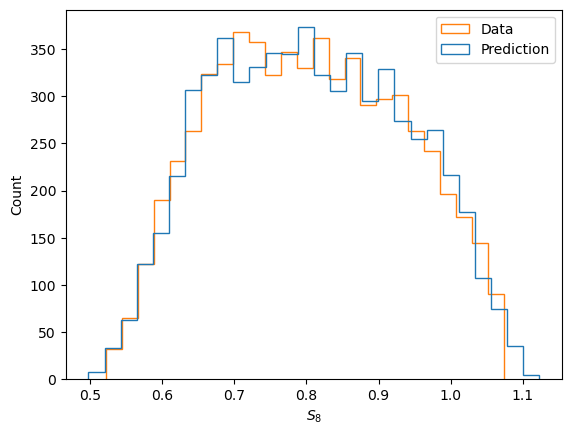

In [13]:
pred = model.predict(x_test)[:,0] * y_std + y_mean

_ = plt.hist(y_test, bins='auto', histtype='step', color='C1', label='Data')
_ = plt.hist(pred[:], bins='auto', histtype='step', color='C0', alpha=1, label='Prediction')

plt.xlabel(r'$S_8$')
plt.ylabel('Count')
plt.legend()

In [14]:
corr = np.corrcoef(y_test, pred)[1,0]
std = np.std(y_test - pred)
mae = np.mean(np.abs(y_test - pred))
outlier = np.where(np.abs(y_test - pred) > 0.05)[0].shape[0] / y_test.shape[0]

print(f"Correlation Coefficients:   {corr:.3f}")
print(f"Mean Absolute Error:        {mae:.3f}")
print(f"Larger than 0.05:           {outlier:.3f}")
print(f"Standard Deviation:         {std:.3f}")


Correlation Coefficients:   0.966
Mean Absolute Error:        0.028
Larger than 0.05:           0.144
Standard Deviation:         0.034


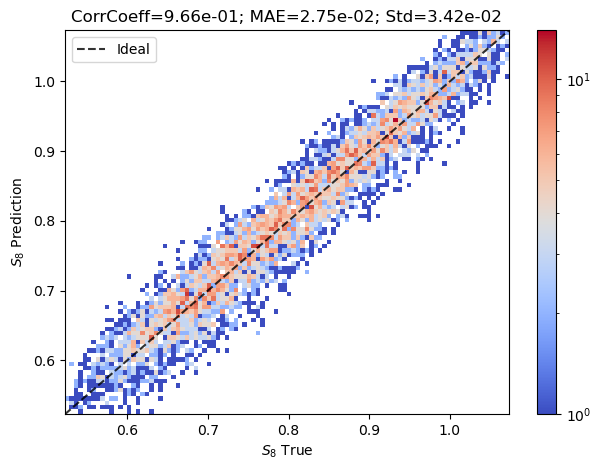

In [18]:
_ = plt.hist2d(y_test, pred, bins=100, cmap='coolwarm', norm='log')
plt.title(f"CorrCoeff={corr:.2e}; MAE={mae:.2e}; Std={std:.2e}", fontsize=12)
plt.xlabel(r'$S_8$ True')
plt.ylabel(r'$S_8$ Prediction')
plt.plot([s8_min, s8_max], [s8_min, s8_max], c='k', ls='--', lw=1.5, alpha=.8 ,label='Ideal')
plt.xlim(s8_min, s8_max)
plt.ylim(s8_min, s8_max)
plt.colorbar()
plt.legend()
plt.tight_layout()

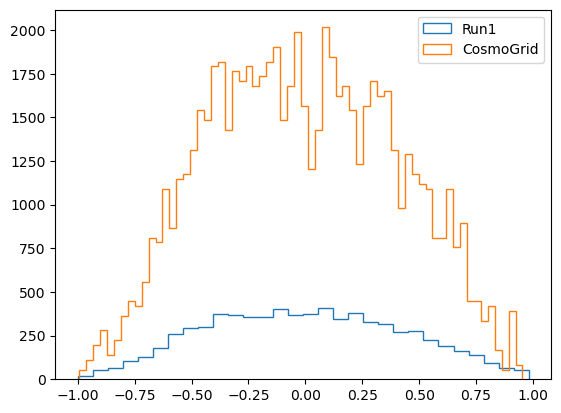

In [9]:
xi_cg = np.load('../data/CosmoGrid/xipm.npy')[:,:,:,:,:,min_scale:]
xip_cg = xi_cg[0]
xim_cg = xi_cg[1]
xi_cg = np.concatenate((xip_cg, xim_cg), axis=1).reshape(70000, -1)

theta_cg = np.load('../data/CosmoGrid/theta.npy')[:70000]
y_cg = (theta_cg[:,4] * np.sqrt(theta_cg[:,0] / 0.3) - y_mean) / y_std

plt.hist(y_train, bins='auto', histtype='step', color='C0', density=False, label='Run1')
plt.hist(y_cg, bins='auto', histtype='step', color='C1', density=False, label='CosmoGrid')
plt.legend()

2188/2188 [==============================] - 3s 1ms/step


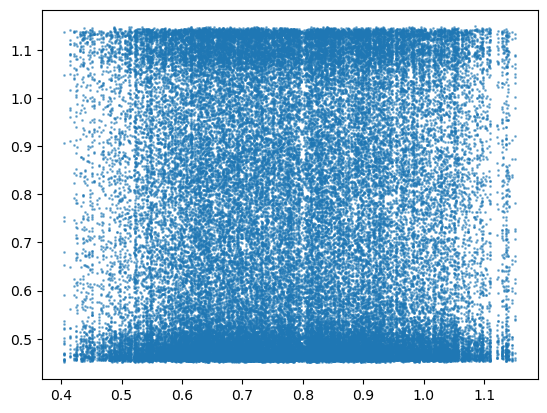

In [10]:
pred_cg = model.predict(xi_cg)[:,0] * y_std + y_mean
y_cg_plot = y_cg * y_std + y_mean
#_ = plt.hist2d(y_cg_plot, pred_cg, bins=100, cmap='coolwarm', norm='log')
plt.scatter(y_cg_plot, pred_cg, s=1, alpha=0.5)

In [11]:
closest_inds = np.argsort(np.abs(y_cg - y[:70000]))[:10]
print(y_cg[closest_inds])
print(y[closest_inds])

plt.plot(x[closest_inds[0]][:10])
plt.plot(xi_cg[closest_inds[0]][:10])

ValueError: operands could not be broadcast together with shapes (70000,) (8994,) 

In [ ]:
xi.shape, xip_cg

((200000, 10, 9, 2),
 array([[[[[ 7.91359199e-06,  7.45738283e-06,  5.94443316e-06, ...,
             4.01935686e-06,  3.18405168e-06,  2.59370322e-06],
           [ 3.99467499e-06,  3.19235270e-06,  2.66428791e-06, ...,
             1.58531783e-06,  1.06496870e-06,  1.09340400e-06],
           [ 1.90511562e-06,  1.65537906e-06,  1.40940992e-06, ...,
             7.38738038e-07,  6.71145134e-07,  3.69897489e-07],
           ...,
           [ 2.74851200e-06,  3.32992466e-06,  2.35187854e-06, ...,
             1.42200126e-06,  9.52652357e-07,  7.27803480e-07],
           [ 1.86462731e-06,  1.63087985e-06,  1.33806857e-06, ...,
             1.04088754e-06,  9.56239365e-07,  6.14250108e-07],
           [ 1.79841524e-06,  1.05735915e-06,  1.79806968e-06, ...,
             8.04854428e-07,  6.28295465e-07,  4.78496989e-07]],
 
          [[ 7.98395522e-06,  7.23680712e-06,  6.02234217e-06, ...,
             3.70267989e-06,  3.09518224e-06,  2.39559869e-06],
           [ 3.96994511e-06,  3.5571

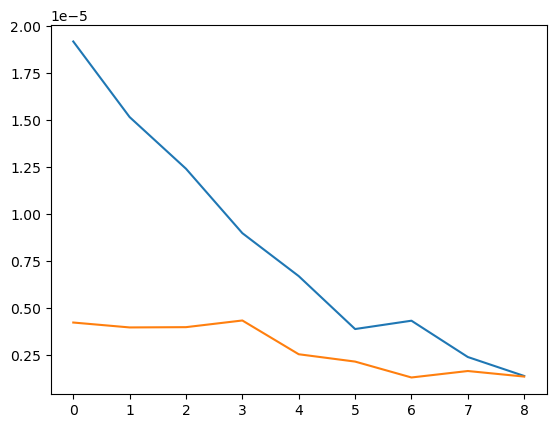

In [ ]:
test = xi[:70000,:,:,0]
test_cg = xip_cg.reshape(70000, 10, 9)

test.shape, test_cg.shape

plt.plot(test[closest_inds[0], 9, :])
plt.plot(test_cg[closest_inds[0], 9, :])

(1e-07, 0.001)

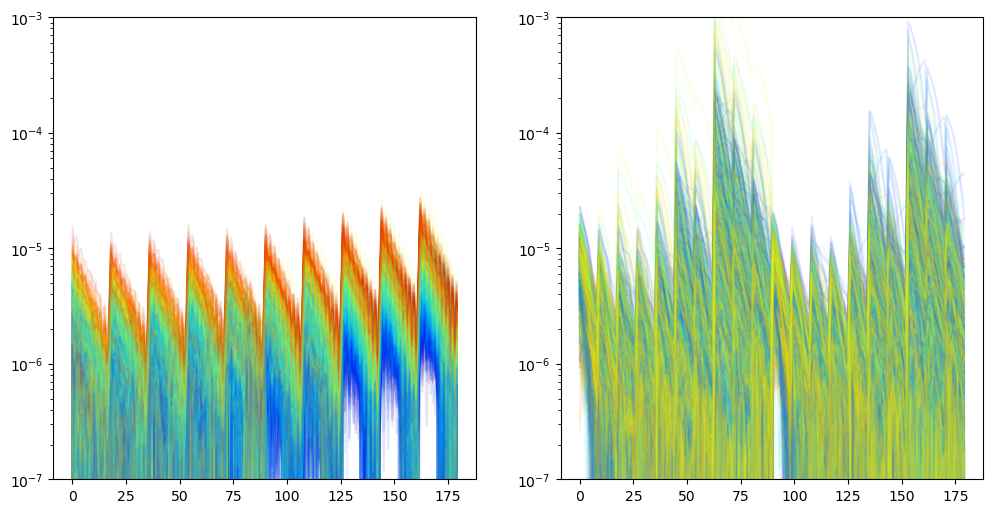

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

theta_c = (y - y.min()) / (y.max()- y.min())
c = plt.cm.jet(theta_c)
for i in range(0,1000, 1):
    ax[0].plot(x[i], c=c[i], alpha=.1)
ax[0].set_yscale('log')
ax[0].set_ylim(1e-7, 1e-3)

theta_c = (y_cg_plot - y_cg_plot.min()) / (y_cg_plot.max()- y_cg_plot.min())
c = plt.cm.jet(theta_c)
for i in range(0,1000, 1):
    ax[1].plot(xi_cg[i], c=c[i], alpha=.1)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-7, 1e-3)